In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
from comparers import ModelComparer
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from IPython.display import display
from sklearn.metrics import classification_report
from comparers import ModelComparer, plot_decision_boundary
from util import RuleClassifier, find_counterfactuals, counterfactuals_to_constraint_matrix, get_complexity,\
                 group_metrics
from surrogate_tree import train_surrogate_tree, plot_surrogate_tree,\
                 get_feature_importances, plot_feature_importances,\
                 tree_to_constraint_matrix, extract_rules, print_rules,\
                 get_pruned_trees, eval_trees

In [2]:
with open('data/task.pickle', 'rb') as f:
    clf_a, clf_b, X, X_display, y, feature_names, categorical_features, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

# Explanations

In [5]:
%%time
trees = []
full_tree = train_surrogate_tree(X, mclass_diff)
trees = get_pruned_trees(full_tree, X, mclass_diff)
tree_it = iter(trees)
len(trees)

CPU times: user 16.3 ms, sys: 2.88 ms, total: 19.2 ms
Wall time: 21.3 ms


10

In [49]:
trees[-1].get_depth()

7

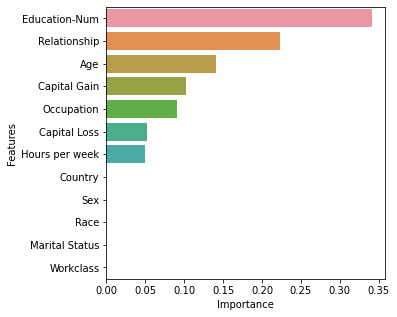

In [6]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

## 2 Leafs

In [7]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.07581818181818184, 1, 2)

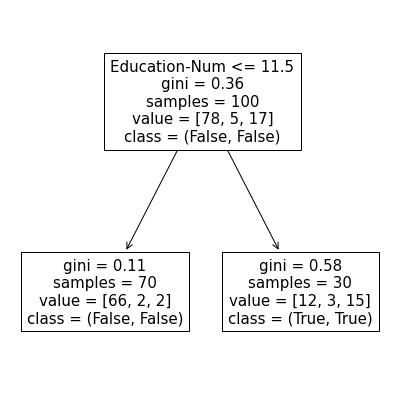

In [8]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(7, 7))

In [9]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, comparer.class_names, labels)

## 3 Leafs

In [10]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.01875, 2, 3)

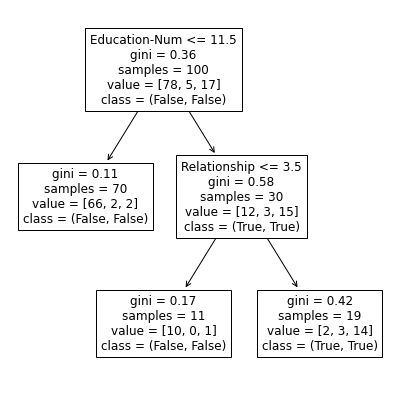

In [11]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(7, 7))

In [12]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, comparer.class_names, labels)

## 5 Leafs

In [13]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.018726890756302524, 4, 5)

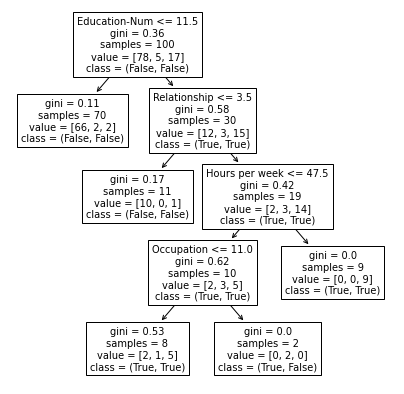

In [14]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(7, 7))

In [15]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. `Education-Num` > 11.5 and Occupation > 11.0 and Relationship > 3.5 and `Hours per week` <= 47.5 => (True, False) [0, 2, 0]


## 7 Leafs

In [16]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.018181818181818184, 4, 7)

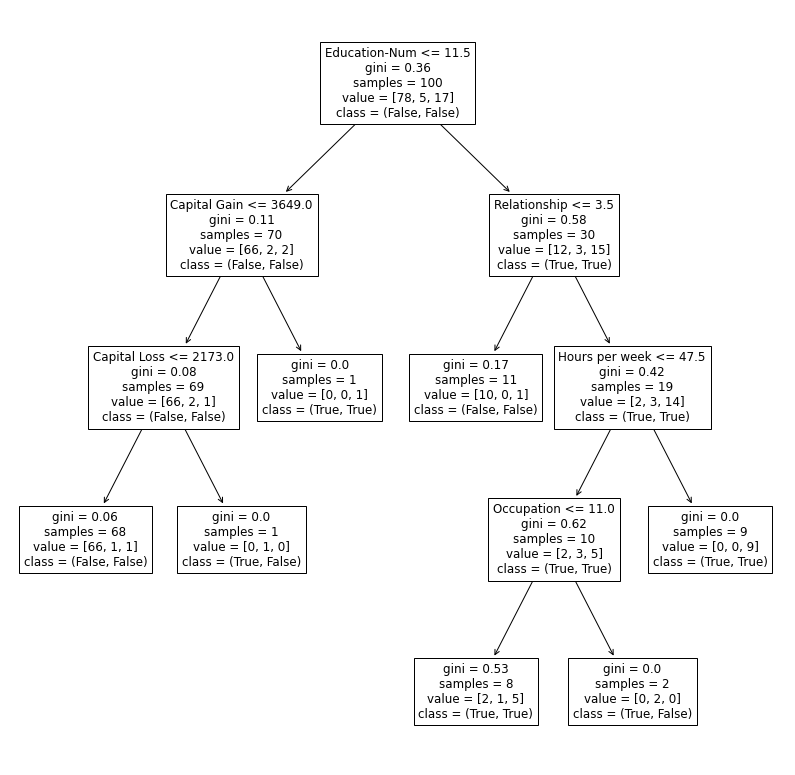

In [17]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(14, 14))

In [18]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. `Education-Num` > 11.5 and Occupation > 11.0 and Relationship > 3.5 and `Hours per week` <= 47.5 => (True, False) [0, 2, 0]
2. `Education-Num` <= 11.5 and `Capital Gain` <= 3649.0 and `Capital Loss` > 2173.0 => (True, False) [0, 1, 0]


## 8 Leafs

In [19]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.015833333333333338, 4, 8)

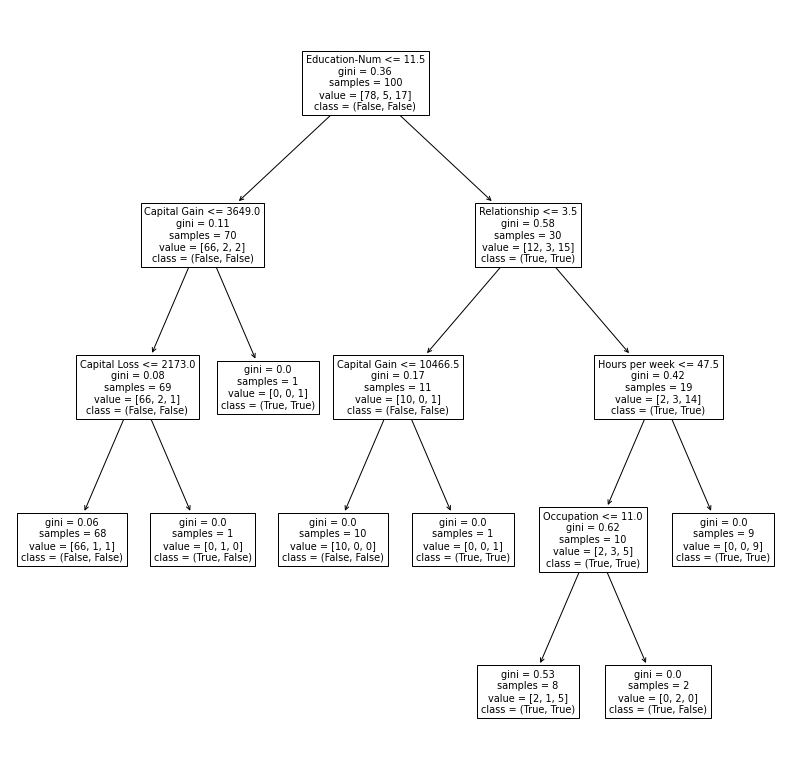

In [20]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(14, 14))

In [21]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. `Education-Num` > 11.5 and Occupation > 11.0 and Relationship > 3.5 and `Hours per week` <= 47.5 => (True, False) [0, 2, 0]
2. `Education-Num` <= 11.5 and `Capital Gain` <= 3649.0 and `Capital Loss` > 2173.0 => (True, False) [0, 1, 0]


## 9 Leafs

In [22]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.01, 5, 9)

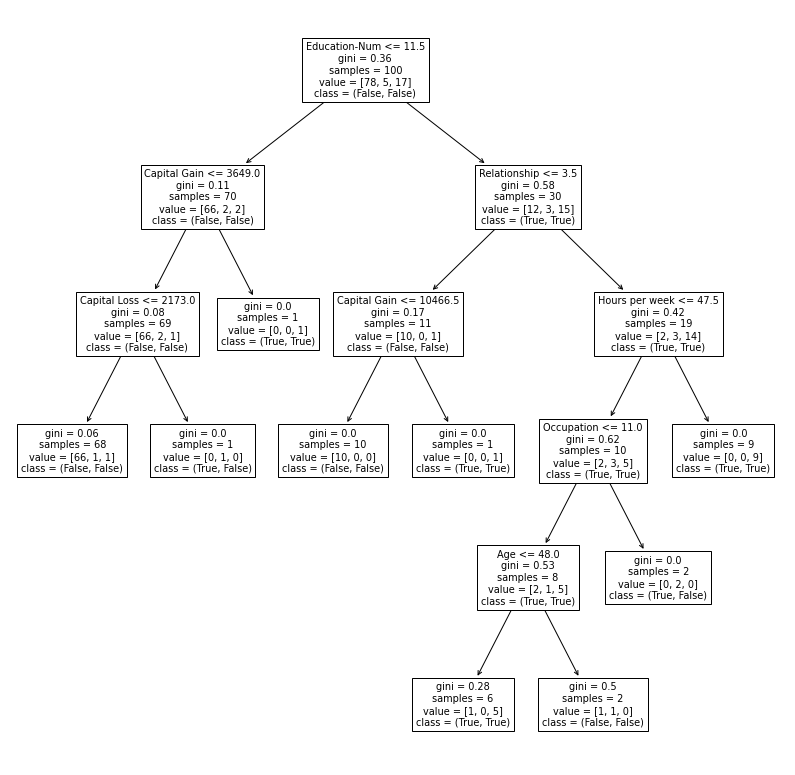

In [23]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(14, 14))

In [24]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. `Education-Num` > 11.5 and Occupation > 11.0 and Relationship > 3.5 and `Hours per week` <= 47.5 => (True, False) [0, 2, 0]
2. `Education-Num` <= 11.5 and `Capital Gain` <= 3649.0 and `Capital Loss` > 2173.0 => (True, False) [0, 1, 0]


## 10 Leafs

In [25]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.009715073529411753, 6, 10)

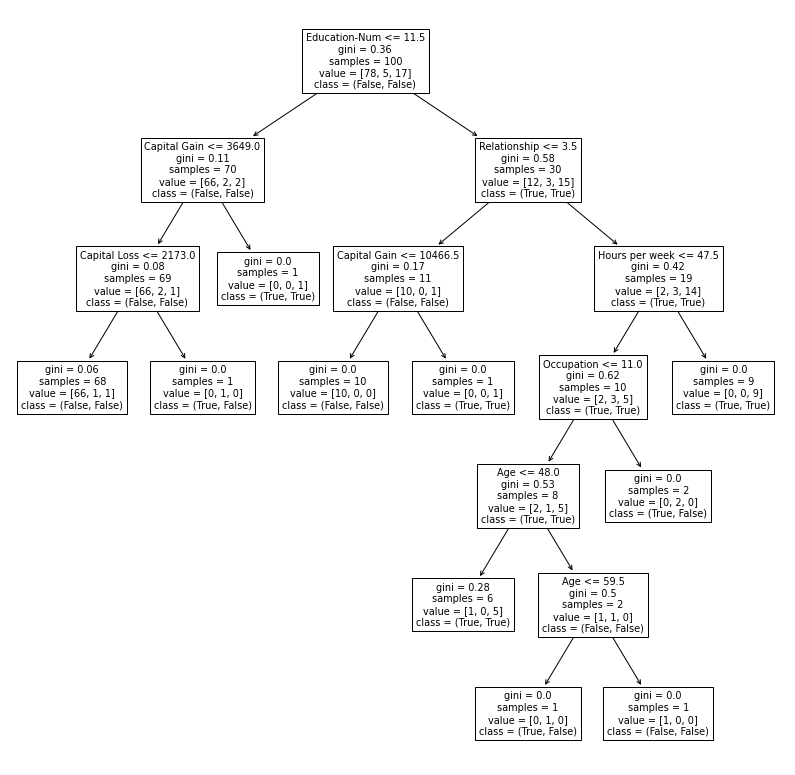

In [26]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(14, 14))

In [27]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. `Education-Num` > 11.5 and Occupation > 11.0 and Relationship > 3.5 and `Hours per week` <= 47.5 => (True, False) [0, 2, 0]
2. 48.0 < Age <= 59.5 and `Education-Num` > 11.5 and Occupation <= 11.0 and Relationship > 3.5 and `Hours per week` <= 47.5 => (True, False) [0, 1, 0]
3. `Education-Num` <= 11.5 and `Capital Gain` <= 3649.0 and `Capital Loss` > 2173.0 => (True, False) [0, 1, 0]


## 12 Leafs

In [28]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.008333333333333333, 6, 12)

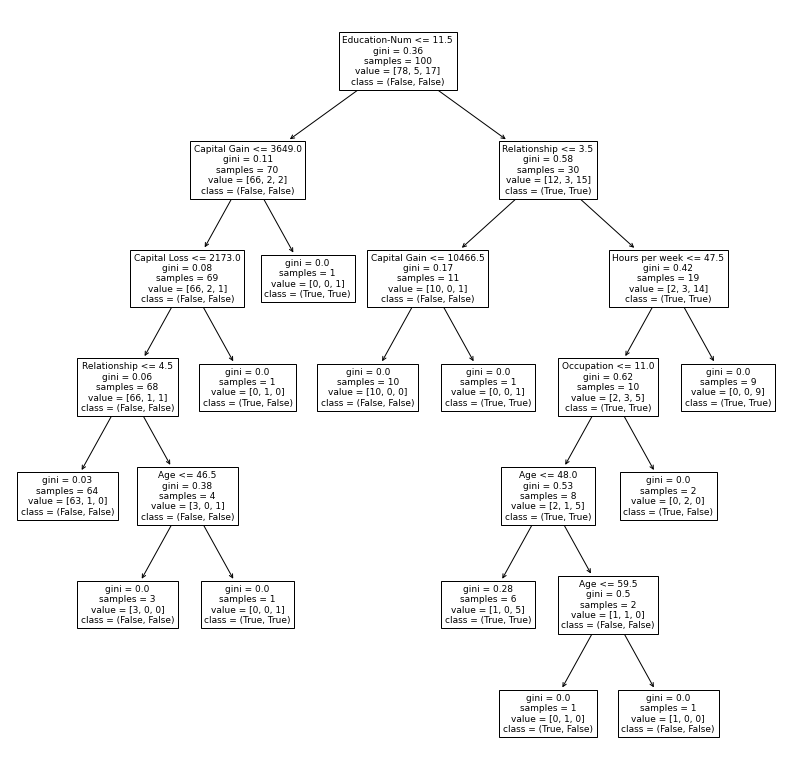

In [29]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(14, 14))

In [30]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. `Education-Num` > 11.5 and Occupation > 11.0 and Relationship > 3.5 and `Hours per week` <= 47.5 => (True, False) [0, 2, 0]
2. 48.0 < Age <= 59.5 and `Education-Num` > 11.5 and Occupation <= 11.0 and Relationship > 3.5 and `Hours per week` <= 47.5 => (True, False) [0, 1, 0]
3. `Education-Num` <= 11.5 and `Capital Gain` <= 3649.0 and `Capital Loss` > 2173.0 => (True, False) [0, 1, 0]


## 14 Leafs

In [31]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0065625, 7, 14)

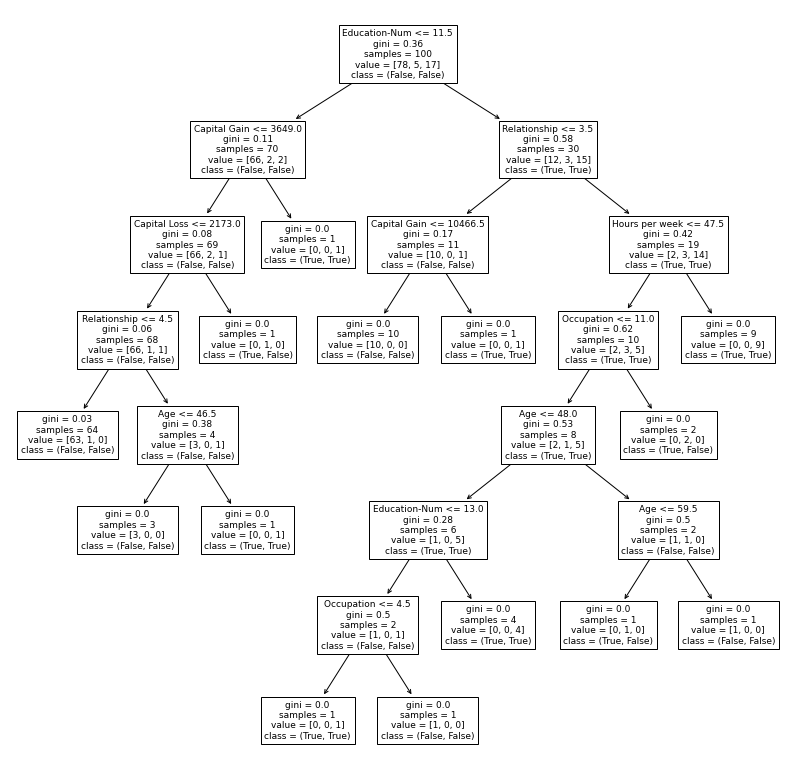

In [32]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(14, 14))

In [33]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. `Education-Num` > 11.5 and Occupation > 11.0 and Relationship > 3.5 and `Hours per week` <= 47.5 => (True, False) [0, 2, 0]
2. 48.0 < Age <= 59.5 and `Education-Num` > 11.5 and Occupation <= 11.0 and Relationship > 3.5 and `Hours per week` <= 47.5 => (True, False) [0, 1, 0]
3. `Education-Num` <= 11.5 and `Capital Gain` <= 3649.0 and `Capital Loss` > 2173.0 => (True, False) [0, 1, 0]


## 17 Leafs

In [34]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0, 7, 17)

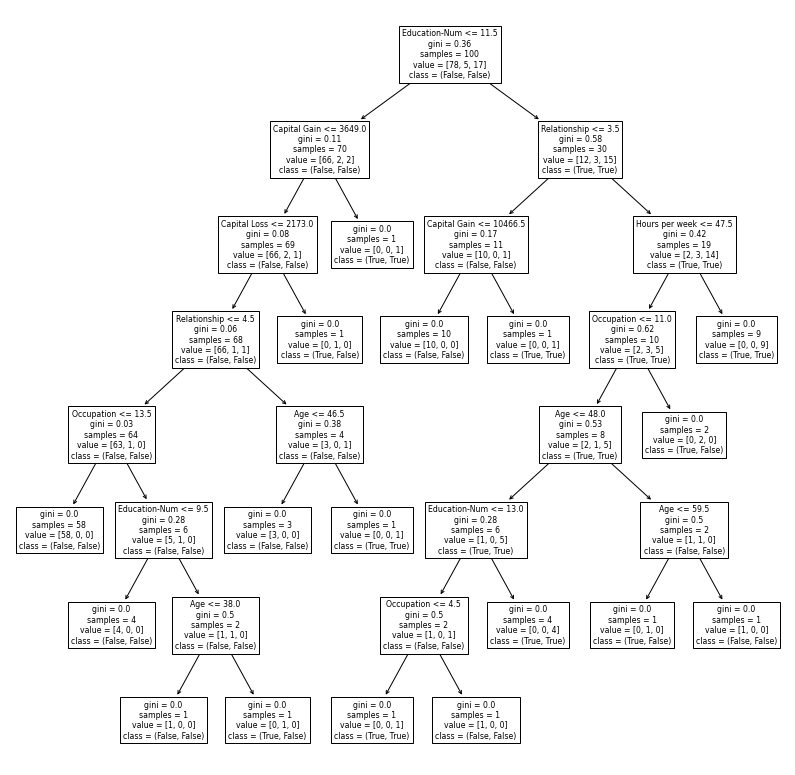

In [35]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(14, 14))

In [36]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. `Education-Num` > 11.5 and Occupation > 11.0 and Relationship > 3.5 and `Hours per week` <= 47.5 => (True, False) [0, 2, 0]
2. 48.0 < Age <= 59.5 and `Education-Num` > 11.5 and Occupation <= 11.0 and Relationship > 3.5 and `Hours per week` <= 47.5 => (True, False) [0, 1, 0]
3. `Education-Num` <= 11.5 and `Capital Gain` <= 3649.0 and `Capital Loss` > 2173.0 => (True, False) [0, 1, 0]
4. Age > 38.0 and 9.5 < `Education-Num` <= 11.5 and Occupation > 13.5 and Relationship <= 4.5 and `Capital Gain` <= 3649.0 and `Capital Loss` <= 2173.0 => (True, False) [0, 1, 0]


# Evaluation

In [37]:
with open('data/test.pickle', 'rb') as f:
    X_test, X_display, y_test = pickle.load(f)

In [38]:
test_labels = comparer.predict_mclass_diff(X_test)

In [39]:
metrics = eval_trees(trees, feature_names, comparer.class_names, X_test=X_test, y_test=test_labels)
metrics

,Precision,Recall,F1 Score,Support,Label,Leafs,Alpha,Rules,Constraints
"(False, False)",0.913744,0.824598,0.866885,3854.0,"(False, False)",2,0.075818,1,1
"(True, True)",0.368018,0.702190,0.482932,685.0,"(True, True)",2,0.075818,1,1
"(False, False)",0.912958,0.968864,0.940081,3854.0,"(False, False)",3,0.018750,2,3
"(True, True)",0.621583,0.630657,0.626087,685.0,"(True, True)",3,0.018750,1,2
"(False, False)",0.912958,0.968864,0.940081,3854.0,"(False, False)",5,0.018727,2,3
"(True, False)",0.338462,0.092437,0.145215,238.0,"(True, False)",5,0.018727,1,4
"(True, True)",0.642857,0.591241,0.615970,685.0,"(True, True)",5,0.018727,2,7
"(False, False)",0.936593,0.954333,0.945380,3854.0,"(False, False)",7,0.018182,2,5
"(True, False)",0.280488,0.096639,0.143750,238.0,"(True, False)",7,0.018182,2,7
"(True, True)",0.652062,0.738686,0.692676,685.0,"(True, True)",7,0.018182,3,9


In [40]:
grouped_metrics, constraints = group_metrics(metrics, by='Alpha')
with open('data/fidelity-baseline.pickle', 'wb') as f:
    pickle.dump((grouped_metrics, constraints), f)

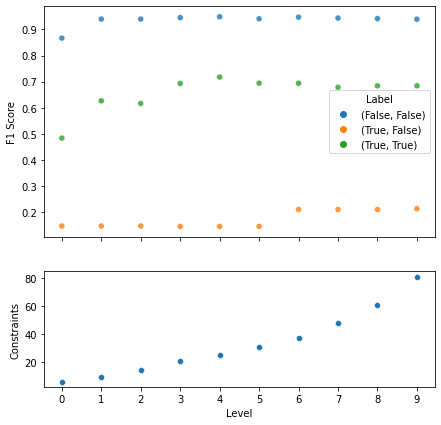

In [41]:
fig, axs = plt.subplots(nrows=2, figsize=(7, 7), sharex='all', gridspec_kw={'height_ratios': [2,1]})
sns.scatterplot(data=grouped_metrics, x='Level', y='F1 Score', hue='Label', alpha=0.8, ax=axs[0])
sns.scatterplot(data=constraints, ax=axs[1])
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

In [42]:
grouped_metrics[grouped_metrics['Label'] == '(True, False)'].describe()

,Precision,Recall,F1 Score,Support,Leafs,Alpha,Rules,Constraints
count,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000,10.000000
mean,0.289104,0.127311,0.170461,238.0,9.200000,0.012481,2.200000,9.200000
std,0.036045,0.042622,0.033556,0.0,4.104198,0.006520,1.032796,5.329165
min,0.240642,0.092437,0.143750,238.0,5.000000,0.000000,1.000000,4.000000
25%,0.264516,0.093487,0.144116,238.0,5.500000,0.008679,1.250000,4.750000
50%,0.280488,0.096639,0.145215,238.0,8.500000,0.012917,2.000000,7.000000
75%,0.323968,0.172269,0.208651,238.0,11.500000,0.018591,3.000000,13.000000
max,0.338462,0.189076,0.211765,238.0,17.000000,0.018727,4.000000,20.000000


In [43]:
grouped_metrics

Label  Precision    Recall  F1 Score  Support  Leafs  \
Level                                                                    
0     0  (False, False)   0.913744  0.824598  0.866885   3854.0    2.0   
      1   (True, False)   0.338462  0.092437  0.145215    238.0    5.0   
      2    (True, True)   0.368018  0.702190  0.482932    685.0    2.0   
1     0  (False, False)   0.912958  0.968864  0.940081   3854.0    3.0   
      1   (True, False)   0.338462  0.092437  0.145215    238.0    5.0   
      2    (True, True)   0.621583  0.630657  0.626087    685.0    3.0   
2     0  (False, False)   0.912958  0.968864  0.940081   3854.0    5.0   
      1   (True, False)   0.338462  0.092437  0.145215    238.0    5.0   
      2    (True, True)   0.642857  0.591241  0.615970    685.0    5.0   
3     0  (False, False)   0.936593  0.954333  0.945380   3854.0    7.0   
      1   (True, False)   0.280488  0.096639  0.143750    238.0    7.0   
      2    (True, True)   0.652062  0.738686  0.692676    685.0    7.0   
4     0  (False, False)   0.943319  0.954333  0.948794   3854.0    8.0   
      1   (True, False)   0.280488  0.096639  0.143750    238.0    8.0   
      2    (True, True)   0.664179  0.779562  0.717260    685.0    8.0   
5     0  (False, False)   0.921223  0.961858  0.941102   3854.0    9.0   
      1   (True, False)   0.280488  0.096639  0.143750    238.0    9.0   
      2    (True, True)   0.696613  0.690511  0.693548    685.0    9.0   
6     0  (False, False)   0.935712  0.959263  0.947341   3854.0   10.0   
      1   (True, False)   0.264516  0.172269  0.208651    238.0   10.0   
      2    (True, True)   0.696613  0.690511  0.693548    685.0   10.0   
7     0  (False, False)   0.937308  0.950441  0.943829   3854.0   12.0   
      1   (True, False)   0.264516  0.172269  0.208651    238.0   12.0   
      2    (True, True)   0.660665  0.696350  0.678038    685.0   12.0   
8     0  (False, False)   0.927099  0.956928  0.941777   3854.0   14.0   
      1   (True, False)   0.264516  0.172269  0.208651    238.0   14.0   
      2    (True, True)   0.700920  0.667153  0.683620    685.0   14.0   
9     0  (False, False)   0.928535  0.950701  0.939487   3854.0   17.0   
      1   (True, False)   0.240642  0.189076  0.211765    238.0   17.0   
      2    (True, True)   0.700920  0.667153  0.683620    685.0   17.0   

            Alpha  Rules  Constraints  
Level                                  
0     0  0.075818    1.0          1.0  
      1  0.018727    1.0          4.0  
      2  0.075818    1.0          1.0  
1     0  0.018750    2.0          3.0  
      1  0.018727    1.0          4.0  
      2  0.018750    1.0          2.0  
2     0  0.018727    2.0          3.0  
      1  0.018727    1.0          4.0  
      2  0.018727    2.0          7.0  
3     0  0.018182    2.0          5.0  
      1  0.018182    2.0          7.0  
      2  0.018182    3.0          9.0  
4     0  0.015833    2.0          6.0  
      1  0.015833    2.0          7.0  
      2  0.015833    4.0         12.0  
5     0  0.010000    3.0         11.0  
      1  0.010000    2.0          7.0  
      2  0.010000    4.0         13.0  
6     0  0.009715    3.0         11.0  
      1  0.009715    3.0         13.0  
      2  0.009715    4.0         13.0  
7     0  0.008333    4.0         17.0  
      1  0.008333    3.0         13.0  
      2  0.008333    5.0         18.0  
8     0  0.006562    5.0         24.0  
      1  0.006562    3.0         13.0  
      2  0.006562    6.0         24.0  
9     0  0.000000    7.0         37.0  
      1  0.000000    4.0         20.0  
      2  0.000000    6.0         24.0

In [44]:
constraints

Level
0     6.0
1     9.0
2    14.0
3    21.0
4    25.0
5    31.0
6    37.0
7    48.0
8    61.0
9    81.0
Name: Constraints, dtype: float64

In [48]:
for label in comparer.class_names:
    print(label)
    display(metrics[metrics['Label'] == label].describe())

(False, False)


,Precision,Recall,F1 Score,Support,Leafs,Alpha,Rules,Constraints
count,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000,10.000000
mean,0.926945,0.945018,0.935476,3854.0,8.700000,0.018192,3.100000,11.800000
std,0.011286,0.042820,0.024314,0.0,4.762119,0.021159,1.791957,11.370527
min,0.912958,0.824598,0.866885,3854.0,2.000000,0.000000,1.000000,1.000000
25%,0.915613,0.951609,0.940081,3854.0,5.500000,0.008679,2.000000,3.500000
50%,0.927817,0.955631,0.941440,3854.0,8.500000,0.012917,2.500000,8.500000
75%,0.936373,0.961209,0.944992,3854.0,11.500000,0.018591,3.750000,15.500000
max,0.943319,0.968864,0.948794,3854.0,17.000000,0.075818,7.000000,37.000000


(False, True)


,Precision,Recall,F1 Score,Support,Leafs,Alpha,Rules,Constraints
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(True, False)


,Precision,Recall,F1 Score,Support,Leafs,Alpha,Rules,Constraints
count,8.000000,8.000000,8.000000,8.0,8.000000,8.000000,8.00000,8.000000
mean,0.276764,0.136029,0.176773,238.0,10.250000,0.010919,2.50000,10.500000
std,0.028292,0.043604,0.034930,0.0,3.918819,0.006381,0.92582,5.182388
min,0.240642,0.092437,0.143750,238.0,5.000000,0.000000,1.00000,4.000000
25%,0.264516,0.096639,0.143750,238.0,7.750000,0.007891,2.00000,7.000000
50%,0.272502,0.134454,0.176933,238.0,9.500000,0.009858,2.50000,10.000000
75%,0.280488,0.172269,0.208651,238.0,12.500000,0.016420,3.00000,13.000000
max,0.338462,0.189076,0.211765,238.0,17.000000,0.018727,4.00000,20.000000


(True, True)


,Precision,Recall,F1 Score,Support,Leafs,Alpha,Rules,Constraints
count,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000,10.000000
mean,0.640443,0.685401,0.656730,685.0,8.700000,0.018192,3.600000,12.300000
std,0.099615,0.052375,0.068616,0.0,4.762119,0.021159,1.837873,8.028422
min,0.368018,0.591241,0.482932,685.0,2.000000,0.000000,1.000000,1.000000
25%,0.645158,0.667153,0.639075,685.0,5.500000,0.008679,2.250000,7.500000
50%,0.662422,0.690511,0.683620,685.0,8.500000,0.012917,4.000000,12.500000
75%,0.696613,0.700730,0.693330,685.0,11.500000,0.018591,4.750000,16.750000
max,0.700920,0.779562,0.717260,685.0,17.000000,0.075818,6.000000,24.000000


# Additional Material

In [6]:
tree = trees[-1]

In [7]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions, latex=True)
for label, rule in zip(labels, rules):
    print(f'\item if ${rule}$, then ${comparer.class_names[label]}$')

\item if $\text{Education-Num} > 12 \land \text{Occupation} > 11 \land \text{Relationship} > 4 \land \text{Hours per week} \leq 48$, then $(True, False)$
\item if $48 < \text{Age} \leq 60 \land \text{Education-Num} > 12 \land \text{Occupation} \leq 11 \land \text{Relationship} > 4 \land \text{Hours per week} \leq 48$, then $(True, False)$
\item if $\text{Education-Num} \leq 12 \land \text{Capital Gain} \leq 3649 \land \text{Capital Loss} > 2173$, then $(True, False)$
\item if $\text{Age} > 38 \land 10 < \text{Education-Num} \leq 12 \land \text{Occupation} > 14 \land \text{Relationship} \leq 4 \land \text{Capital Gain} \leq 3649 \land \text{Capital Loss} \leq 2173$, then $(True, False)$
